In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import *

In [24]:
# Load and preprocess the dataset
df = pd.read_csv('Base de dados\\dados.csv', sep=';')
df = df[['data', 'preco']]
df = df.rename(columns={'data': 'ds', 'preco': 'y'})
df['ds'] = pd.to_datetime(df['ds']) 


In [25]:
# Display the dataframe
df

,ds,y
0,2024-11-18,"74,35"
1,2024-11-15,"73,45"
2,2024-11-14,"73,39"
3,2024-11-13,"72,86"
4,2024-11-12,"72,56"
...,...,...
11297,1987-05-26,"18,63"
11298,1987-05-25,"18,60"
11299,1987-05-22,"18,55"
11300,1987-05-21,"18,45"


In [26]:
# Filter the dataframe to include data from November 2014 onwards
df = df.loc[df['ds'] >= pd.to_datetime('2014-11-01')]

In [27]:
# Display the filtered dataframe
df

,ds,y
0,2024-11-18,"74,35"
1,2024-11-15,"73,45"
2,2024-11-14,"73,39"
3,2024-11-13,"72,86"
4,2024-11-12,"72,56"
...,...,...
2969,2014-11-05,"82,88"
2970,2014-11-04,"84,17"
2971,2014-11-03,"85,50"
2972,2014-11-02,"86,91"


In [28]:
# Create a copy of the dataframe for Prophet
df_prophet = df.copy()

In [29]:
# Convert the 'y' column to float
df_prophet['y'] = df_prophet['y'].str.replace(',', '.').astype(float)
# Display the first few rows of the dataframe
df_prophet.head()

,ds,y
0,2024-11-18,74.35
1,2024-11-15,73.45
2,2024-11-14,73.39
3,2024-11-13,72.86
4,2024-11-12,72.56


In [30]:
# Split the data into training and validation sets
ratio_treino = 0.8

separar_index = int(len(df_prophet) * ratio_treino)

treino = df_prophet.iloc[:separar_index]

valid = df_prophet.iloc[separar_index:]

h = valid.index.nunique()


In [31]:
# Define the WMAPE function
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [32]:
# Print the sizes of the training and validation sets
print(f'Treino: {len(treino)}')
print(f'Teste: {len(valid)}')
print(f'% teste: {len(valid)/len(treino):.2%}')

Treino: 2379
Teste: 595
% teste: 25.01%


In [33]:
# Reset the index and fit the Prophet model
df_prophet.reset_index(inplace=True)

model = Prophet()
model.fit(treino)  # Train on treino

# Perform cross-validation
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='90 days')

# Calculate performance metrics
df_p = performance_metrics(df_cv)

# Print the performance metrics
print(df_p)


00:42:20 - cmdstanpy - INFO - Chain [1] start processing
00:42:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/15 [00:00<?, ?it/s]

00:42:22 - cmdstanpy - INFO - Chain [1] start processing
00:42:22 - cmdstanpy - INFO - Chain [1] done processing
00:42:22 - cmdstanpy - INFO - Chain [1] start processing
00:42:22 - cmdstanpy - INFO - Chain [1] done processing
00:42:22 - cmdstanpy - INFO - Chain [1] start processing
00:42:22 - cmdstanpy - INFO - Chain [1] done processing
00:42:23 - cmdstanpy - INFO - Chain [1] start processing
00:42:23 - cmdstanpy - INFO - Chain [1] done processing
00:42:23 - cmdstanpy - INFO - Chain [1] start processing
00:42:23 - cmdstanpy - INFO - Chain [1] done processing
00:42:23 - cmdstanpy - INFO - Chain [1] start processing
00:42:24 - cmdstanpy - INFO - Chain [1] done processing
00:42:24 - cmdstanpy - INFO - Chain [1] start processing
00:42:24 - cmdstanpy - INFO - Chain [1] done processing
00:42:24 - cmdstanpy - INFO - Chain [1] start processing
00:42:24 - cmdstanpy - INFO - Chain [1] done processing
00:42:25 - cmdstanpy - INFO - Chain [1] start processing
00:42:25 - cmdstanpy - INFO - Chain [1]

   horizon         mse       rmse        mae      mape     mdape     smape  \
0   9 days  227.615732  15.086939  11.243806  0.188796  0.092856  0.171333   
1  10 days  236.900707  15.391579  11.538383  0.199730  0.093954  0.178631   
2  11 days  230.997112  15.198589  11.358863  0.198053  0.098745  0.175320   
3  12 days  225.003176  15.000106  11.352283  0.202114  0.107203  0.176017   
4  13 days  227.475585  15.082294  11.632400  0.207908  0.117114  0.182265   
..     ...         ...        ...        ...       ...       ...       ...   
77 86 days  345.827930  18.596449  15.598046  0.227109  0.161214  0.226563   
78 87 days  349.237688  18.687902  15.771855  0.229202  0.159612  0.227748   
79 88 days  350.897387  18.732255  15.985538  0.232566  0.169472  0.231337   
80 89 days  361.931413  19.024495  16.293303  0.237404  0.175757  0.235726   
81 90 days  380.821713  19.514654  16.687074  0.243591  0.197381  0.242562   

    coverage  
0   0.378788  
1   0.353535  
2   0.363636  
3  

In [34]:
# Calculate MAPE and WMAPE for cross-validation results
df_cv['error'] = np.abs(df_cv['y'] - df_cv['yhat']) / df_cv['y']
mape5 = df_cv['error'].mean() * 100
# wmape_cross = np.sum(np.abs(df_cv['y'] - df_cv['yhat'])) / np.sum(df_cv['y'])
# Calcular o WMAPE
wmape5 = np.sum(np.abs(df_cv['y'] - df_cv['yhat'])) / np.sum(df_cv['y']) * 100

print(f'MAPE: {mape5:.2f}%')
print(f'WMAPE: {wmape5:.2f}%')

MAPE: 24.18%
WMAPE: 19.10%


In [35]:
# Reset the index and split the data into training and testing sets
df_prophet.reset_index(inplace=True)

dados_treino = df_prophet.sample(frac=0.75, random_state=18)
dados_teste = df_prophet.drop(dados_treino.index)

# Fit the Prophet model on the training data
modelo = Prophet(daily_seasonality=True)
modelo.fit(dados_treino)

# Make future predictions
futuro = modelo.make_future_dataframe(periods=365)
futuro.tail()

00:42:29 - cmdstanpy - INFO - Chain [1] start processing
00:42:30 - cmdstanpy - INFO - Chain [1] done processing


,ds
2590,2025-11-14
2591,2025-11-15
2592,2025-11-16
2593,2025-11-17
2594,2025-11-18


In [36]:
# Predict future values
forecast = modelo.predict(futuro)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2590,2025-11-14,66.442574,49.900318,82.179964
2591,2025-11-15,65.671595,49.469194,80.481719
2592,2025-11-16,66.103396,50.511458,79.900281
2593,2025-11-17,65.974775,49.448108,81.689793
2594,2025-11-18,65.504685,48.616099,81.180167


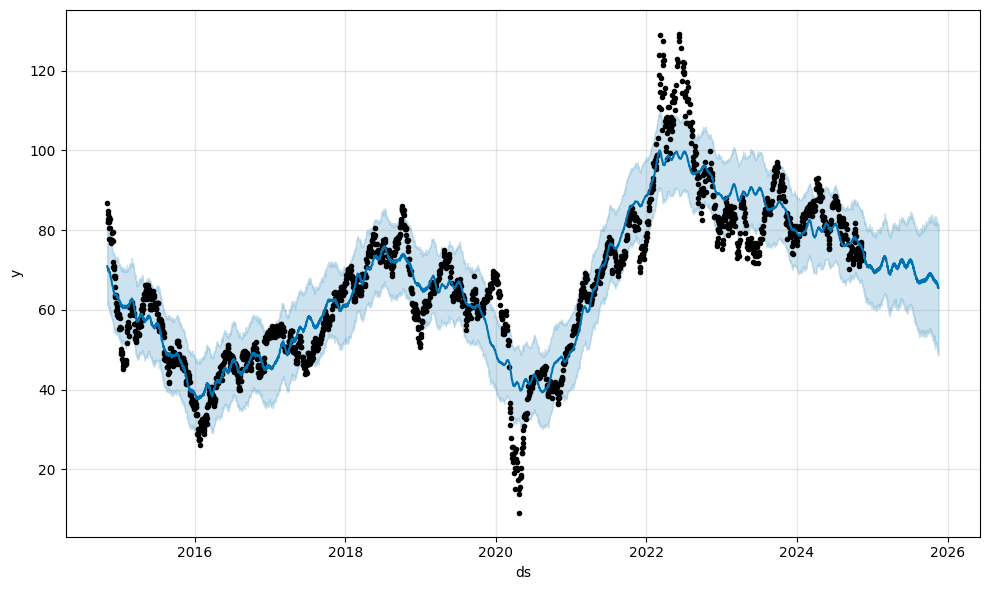

In [37]:
# Plot the forecast
fig1 = modelo.plot(forecast)

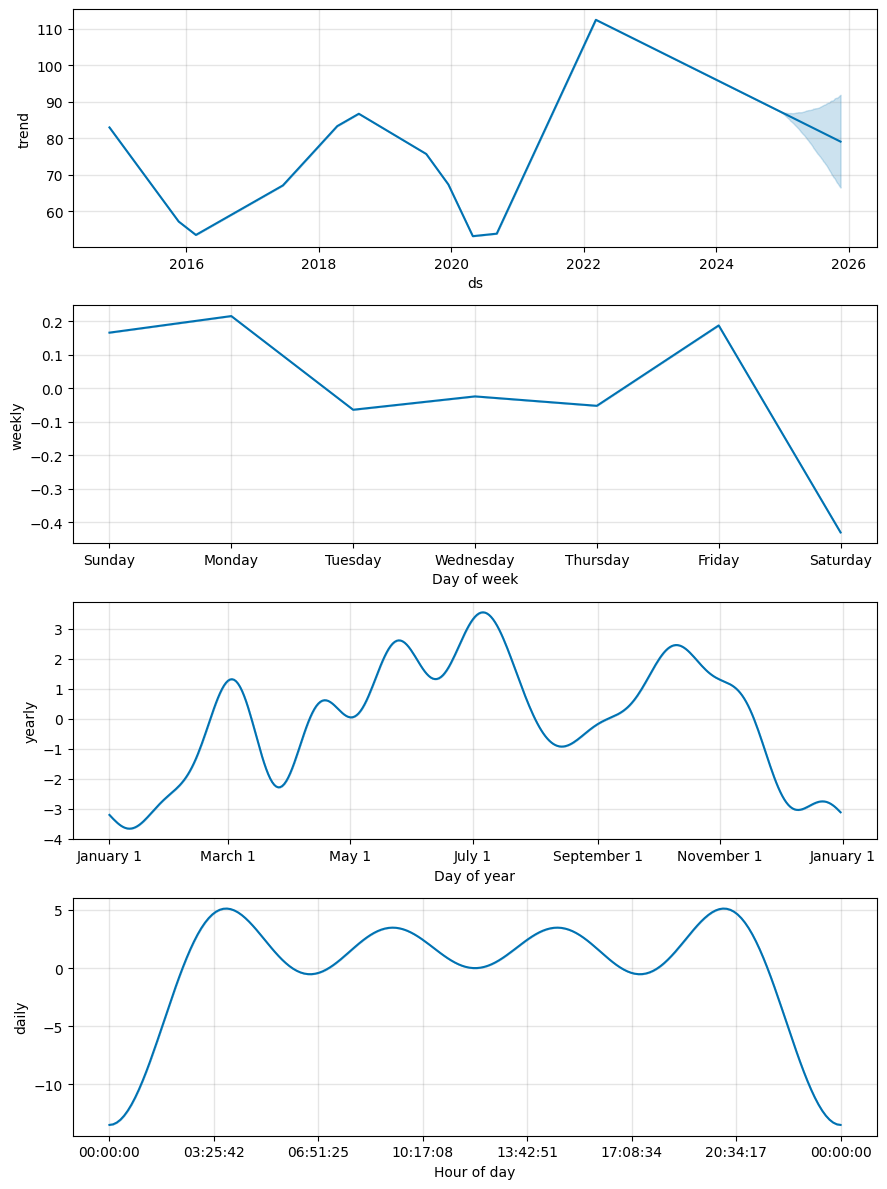

In [38]:
# Plot the forecast components
fig2 = modelo.plot_components(forecast)

In [39]:
# Prepare the data for MAPE calculation
y_pred = ['ds', 'yhat']
y_true = ['ds', 'y']

forecast = forecast[y_pred]
true = valid[y_true] 

# Merge the forecast and true values
result = pd.merge(forecast, true, on='ds', how='inner')
# Calculate MAPE
result['MAPE'] = np.abs((result['y'] - result['yhat']) / result['y']) * 100

In [40]:
# Calculate WMAPE and print the result
wmape5 = wmape(result['y'], result['yhat'])
print(f'WMAPE: {wmape5:.2%}')

WMAPE: 8.55%


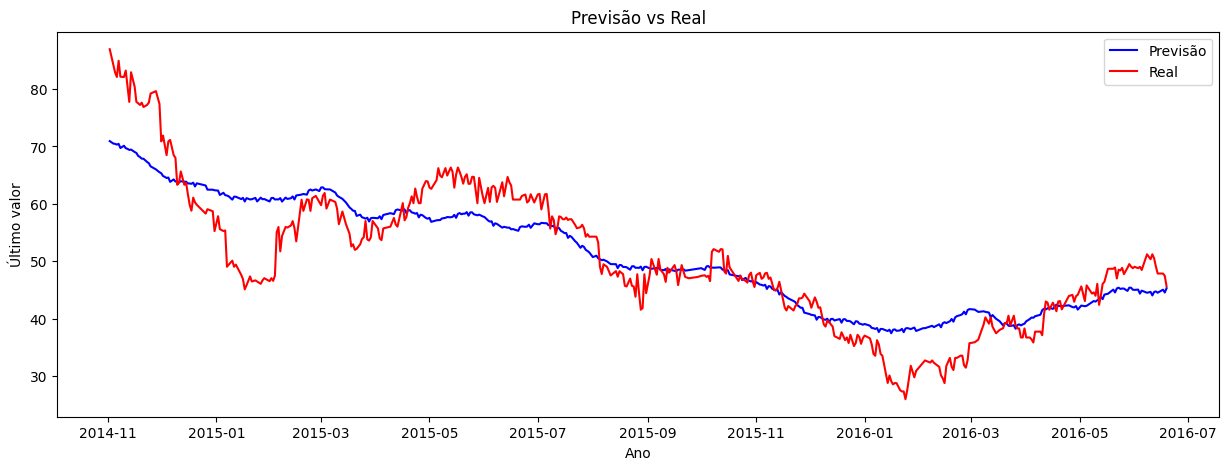

In [41]:
# Plot the forecast vs real values
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(result['ds'], result['yhat'], label='Previsão', color='b')
ax.plot(result['ds'], result['y'], label='Real', color='r')
ax.set_title('Previsão vs Real')
ax.set_xlabel('Ano')
ax.set_ylabel('Último valor')
ax.legend()
plt.show()
